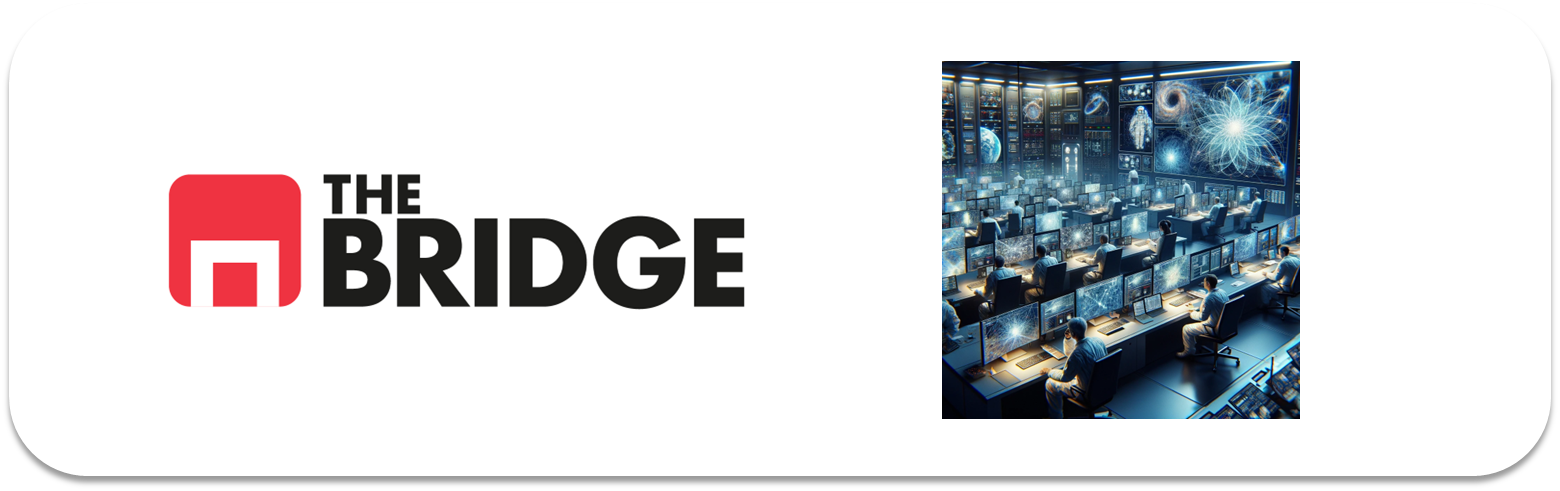

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning con CNN**

* La práctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcción de un modelo de clasificación de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.utils import shuffle
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from tensorflow.keras import Model
import pandas as pd
# ignore warnings
import warnings
warnings.filterwarnings("ignore")
import keras
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.


### Se pide

1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

EXTRA:
- Repetir el transfer learning empleando aumentado de imágenes.



In [8]:
ROOT_PATH = './data/'
TRAIN_PATH = ROOT_PATH + "seg_train/"
TEST_PATH = ROOT_PATH + "seg_test/"

In [9]:
def read_data(directorio, reshape_dim = (32,32)):
    X = [] 
    y = []
    for folder in os.listdir(directorio):
        print(folder)
        if os.path.isdir('/'.join([directorio, folder])):
            for file in os.listdir('/'.join([directorio, folder])):

                image = cv2.imread('/'.join([directorio, folder, file]))
                image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 32x32

                X.append(image)
                y.append(folder)

    return np.array(X),np.array(y)

In [10]:
X_train,y_train = read_data(TRAIN_PATH)
X_test, y_test = read_data(TEST_PATH) # Nota: podríamos dejar la creación de X_test para el final antes de usarlo y así ahorra memoria mientras no tengamos que emplearlo

forest
buildings
.DS_Store
glacier
street
mountain
sea
forest
buildings
glacier
street
mountain
sea


In [11]:
print('X train shape: ', X_train.shape)
print('Y train shape: ', y_train.shape)

X train shape:  (14034, 32, 32, 3)
Y train shape:  (14034,)


In [12]:
print('X train shape: ', X_test.shape)
print('Y train shape: ', y_test.shape)

X train shape:  (3000, 32, 32, 3)
Y train shape:  (3000,)


In [13]:
def show_images_batch(paisajes, names = [], n_cols = 5, size_scale = 2):
    n_rows = ((len(paisajes) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, paisaje in enumerate(paisajes):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(paisaje, cmap = "Greys")
        plt.axis("off")
        if len(names):
            plt.title(names[index])

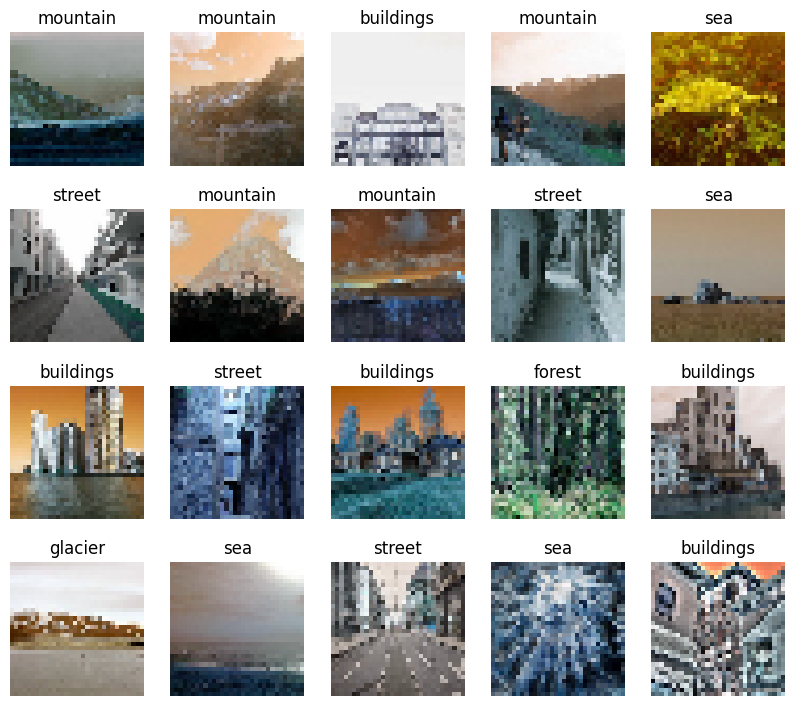

In [14]:
indices = np.random.randint(0,len(X_train),20)
show_images_batch(X_train[indices], names = y_train[indices], n_cols = 5)

In [15]:
targets = pd.Series(y_train)
targets.value_counts(True)

mountain     0.178994
glacier      0.171298
street       0.169731
sea          0.162035
forest       0.161821
buildings    0.156121
Name: proportion, dtype: float64

In [16]:
X_train = X_train/255
X_test = X_test/255

In [17]:
# Primero definimos las capas de la red, en este caso partimos de 30 filtros de 3x3, seguido de una capa de pooling de 2x2,
# El input shape es el tamaño de las imágenes de entrada, en nuestro caso 32x32x3. 
# El tamaño del kernel es pequeño pero suele ser de este tipo y más con resoluciones tan bajas, el número de filtros está escogido de aquella manera,
# juega con el número de filtros.

capas = [keras.layers.Conv2D(filters = 30, kernel_size = (3, 3),
                            input_shape = (X_train[0].shape), 
                            padding = "same",
                            activation = 'relu'),
         keras.layers.MaxPooling2D(pool_size = (2, 2)),

# Añadimos otra capa de convolución y pooling
         keras.layers.Conv2D(filters = 15, 
                             kernel_size = (3, 3),
                             padding = "same", 
                             activation = 'relu'),
         keras.layers.MaxPooling2D(pool_size = (2, 2)),

# Añadimos una capa de flatten para convertir la salida de la capa de pooling en un vector
         keras.layers.Flatten(),

# Añadimos dos capas densas para la clasificación 
         keras.layers.Dense(units = 150, activation = 'relu'),
         keras.layers.Dense(units = 100, activation = 'relu'),

# Añadimos la capa de salida con 6 neuronas, una por cada clase
         keras.layers.Dense(6, activation = 'softmax')]

# Creamos el modelo
model = keras.Sequential(capas)

In [18]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 30)     │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 30)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 15)     │         4,065 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 15)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 150)            │       144,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        15,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,761 (643.60 KB)

 Trainable params: 164,761 (643.60 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
mapa = {tipo:indice for indice,tipo in enumerate(targets.unique())} # Rehusando la serie que creamos para ver la distribución del target
mapa

{'forest': 0,
 'buildings': 1,
 'glacier': 2,
 'street': 3,
 'mountain': 4,
 'sea': 5}

In [21]:
y_train_num = np.array([mapa[y] for y in y_train])
y_test_num = np.array([mapa[y] for y in y_test])

In [22]:
X_train, y_train_num = shuffle(X_train, y_train_num)

In [23]:
history = model.fit(X_train,
                    y_train_num,
                    validation_split = 0.2,
                    epochs = 100,
                    batch_size = 32, callbacks= [keras.callbacks.EarlyStopping(patience = 10, restore_best_weights= True)]) # Queremos recuperar los pesos de la mejor de las epocas durante el periodo de patience

Epoch 1/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4818 - loss: 1.2775 - val_accuracy: 0.6003 - val_loss: 0.9987
Epoch 2/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6478 - loss: 0.9350 - val_accuracy: 0.6690 - val_loss: 0.8657
Epoch 3/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7059 - loss: 0.7830 - val_accuracy: 0.7164 - val_loss: 0.7761
Epoch 4/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7518 - loss: 0.6706 - val_accuracy: 0.7488 - val_loss: 0.6890
Epoch 5/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7767 - loss: 0.6073 - val_accuracy: 0.7435 - val_loss: 0.7074
Epoch 6/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8048 - loss: 0.5359 - val_accuracy: 0.7727 - val_loss: 0.6408
Epoch 7/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8217 - loss: 0.4867 - val_accuracy: 0.7663 - val_loss: 0.6526
Epoch 8/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8495 - loss: 0.4262 - val_ac

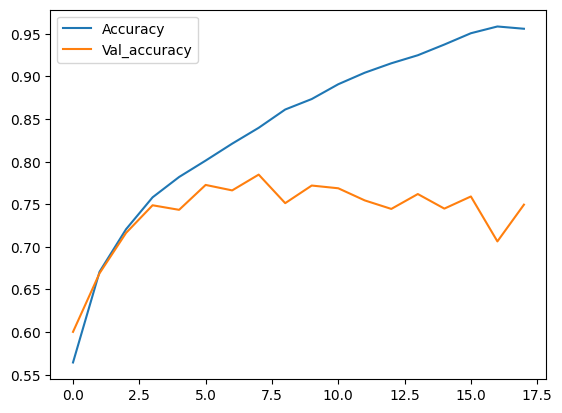

In [24]:
# Representamos el objeto history
history_df = pd.DataFrame(history.history)
plt.plot(history_df['accuracy'], label = 'Accuracy')
plt.plot(history_df['val_accuracy'], label = 'Val_accuracy')

plt.legend();

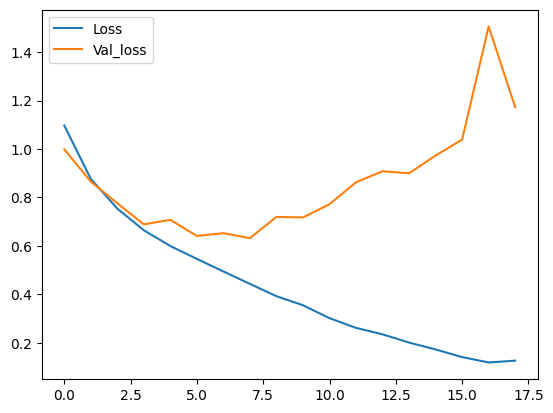

In [25]:
plt.plot(history_df['loss'], label = 'Loss')
plt.plot(history_df['val_loss'], label = 'Val_loss')

plt.legend();

In [26]:
model.evaluate(X_test, y_test_num)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8038 - loss: 0.5705


[0.6490252017974854, 0.7749999761581421]

In [27]:
y_pred = [ np.argmax(prediction) for prediction in model.predict(X_test)]

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [28]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
inverse_map = {valor:clave for clave,valor in mapa.items()}
y_test_labels = [inverse_map[y] for y in y_test_num]
y_pred_labels = [inverse_map[y] for y in y_pred]
print(classification_report(y_test_labels, y_pred_labels))

              precision    recall  f1-score   support

   buildings       0.68      0.74      0.71       437
      forest       0.96      0.85      0.90       474
     glacier       0.74      0.77      0.76       553
    mountain       0.78      0.73      0.75       525
         sea       0.76      0.73      0.74       510
      street       0.76      0.83      0.79       501

    accuracy                           0.78      3000
   macro avg       0.78      0.78      0.78      3000
weighted avg       0.78      0.78      0.78      3000



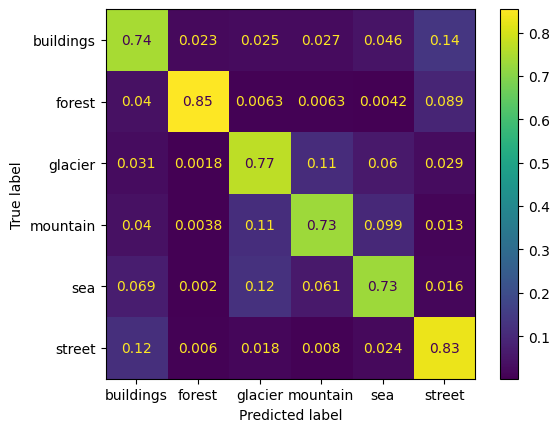

In [29]:
ConfusionMatrixDisplay.from_predictions(y_test_labels, y_pred_labels, normalize="true")

In [30]:
IMG_SIZE = 96

Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 33s 90ms/step - accuracy: 0.2005 - loss: 1.6619 - val_accuracy: 0.0000e+00 - val_loss: 5.5351
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 25s 71ms/step - accuracy: 0.2065 - loss: 1.6160 - val_accuracy: 0.0000e+00 - val_loss: 5.9682
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 24s 69ms/step - accuracy: 0.2083 - loss: 1.6139 - val_accuracy: 0.0000e+00 - val_loss: 5.9784
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 25s 71ms/step - accuracy: 0.2077 - loss: 1.6138 - val_accuracy: 0.0000e+00 - val_loss: 5.8537
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 26s 73ms/step - accuracy: 0.2122 - loss: 1.6116 - val_accuracy: 0.0000e+00 - val_loss: 6.4025
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 27s 76ms/step - accuracy: 0.2150 - loss: 1.6089 - val_accuracy: 0.0000e+00 - val_loss: 5.4432
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 27s 76ms/step - accuracy: 0.2009 - loss: 1.6102 - val_accuracy: 0.0000e+00 - val_loss: 6.2558
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 26s 75ms/step - accura

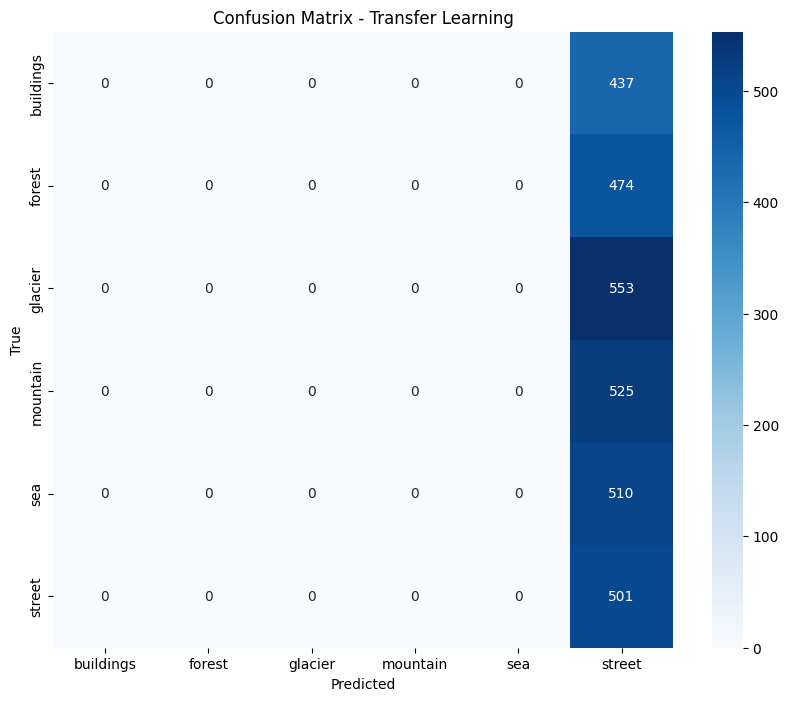

In [32]:
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


# Redimensionar y preprocesar

IMG_SIZE = 96

# Redimensionar imágenes
X_train_resized = np.array([cv2.resize(img, (IMG_SIZE, IMG_SIZE)) for img in X_train])
X_test_resized = np.array([cv2.resize(img, (IMG_SIZE, IMG_SIZE)) for img in X_test])

# Preprocesamiento específico de MobileNetV2
X_train_pp = preprocess_input(X_train_resized)
X_test_pp = preprocess_input(X_test_resized)

# Convertir etiquetas a números y luego a one-hot
label_encoder = LabelEncoder()
y_train_int = label_encoder.fit_transform(y_train)
y_test_int = label_encoder.transform(y_test)

y_train_cat = to_categorical(y_train_int)
y_test_cat = to_categorical(y_test_int)

class_names = label_encoder.classes_

# Crear el modelo base
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Transfer learning (congelado)

# Añadir cabeza personalizada
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
output = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar modelo (transfer learning)
history = model.fit(X_train_pp, y_train_cat, epochs=10, batch_size=32, validation_split=0.2)

# Evaluación
loss, acc = model.evaluate(X_test_pp, y_test_cat)
print(f"Test Accuracy: {acc:.2f}")

y_pred = np.argmax(model.predict(X_test_pp), axis=1)

# Reporte
print(classification_report(y_test_int, y_pred, target_names=class_names))

# Matriz de confusión
cm = confusion_matrix(y_test_int, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Transfer Learning")
plt.show()

El bajo rendimiento del modelo de Transfer Learning (con una accuracy del 17%) se debe principalmente a una incompatibilidad entre las características del dataset y la arquitectura utilizada. Las redes preentrenadas como InceptionV3, ResNet50 o VGG-19 fueron diseñadas y entrenadas sobre ImageNet, un dataset compuesto por imágenes a color de alta resolución (224×224 o más) y con texturas, formas y detalles ricos.

En cambio, en este proyecto se utilizaron imágenes de muy baja resolución (32×32), que contienen mucho menos detalle visual, lo cual dificulta que los filtros preentrenados en ImageNet puedan generalizar o detectar patrones útiles.

In [34]:
# Descongelar las últimas capas de la base MobileNetV2
base_model.trainable = True

# Solo ajusto las ultimas 30 capas
for layer in base_model.layers[:-30]:
    layer.trainable = False


In [35]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(1e-5),  # lr bajo para no destruir pesos preentrenados
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [36]:
history_finetune = model.fit(X_train_pp, y_train_cat, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 35s 90ms/step - accuracy: 0.2079 - loss: 1.6253 - val_accuracy: 0.1899 - val_loss: 7.3869
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 30s 85ms/step - accuracy: 0.2231 - loss: 1.6086 - val_accuracy: 0.1899 - val_loss: 9.1485
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 31s 89ms/step - accuracy: 0.2236 - loss: 1.6046 - val_accuracy: 3.5625e-04 - val_loss: 8.8322
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 31s 89ms/step - accuracy: 0.2342 - loss: 1.6015 - val_accuracy: 0.0000e+00 - val_loss: 9.1410
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 32s 90ms/step - accuracy: 0.2399 - loss: 1.5978 - val_accuracy: 0.0000e+00 - val_loss: 10.6648
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 32s 92ms/step - accuracy: 0.2502 - loss: 1.5919 - val_accuracy: 7.1250e-04 - val_loss: 11.8872
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 31s 89ms/step - accuracy: 0.2533 - loss: 1.5906 - val_accuracy: 0.0000e+00 - val_loss: 11.3983
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 32s 91ms/step - accuracy: 0

94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.1747 - loss: 1.7937
Test Accuracy after Fine-Tuning: 0.18
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step
              precision    recall  f1-score   support

   buildings       0.00      0.00      0.00       437
      forest       0.07      0.00      0.00       474
     glacier       0.19      1.00      0.31       553
    mountain       0.00      0.00      0.00       525
         sea       0.00      0.00      0.00       510
      street       0.00      0.00      0.00       501

    accuracy                           0.18      3000
   macro avg       0.04      0.17      0.05      3000
weighted avg       0.04      0.18      0.06      3000



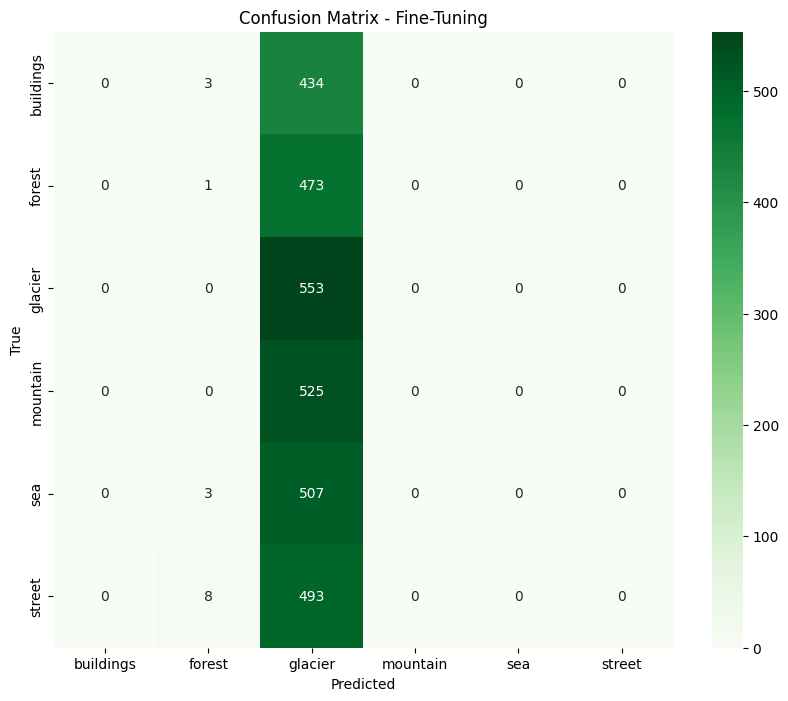

In [37]:
# Evaluación en test
loss, acc = model.evaluate(X_test_pp, y_test_cat)
print(f"Test Accuracy after Fine-Tuning: {acc:.2f}")

# Predicciones y métricas
y_pred_ft = np.argmax(model.predict(X_test_pp), axis=1)

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Reporte
print(classification_report(y_test_int, y_pred_ft, target_names=class_names))

# Matriz de confusión
cm_ft = confusion_matrix(y_test_int, y_pred_ft)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_ft, annot=True, fmt="d", xticklabels=class_names,
            yticklabels=class_names, cmap="Greens")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Fine-Tuning")
plt.show()


Estos resultados refuerzas mi conclusion anterior

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

# 1. Modelo base (sin fine-tuning)
report_base = classification_report(y_test_int, y_pred, target_names=class_names, output_dict=True)

# 2. Modelo fine-tuned
report_ft = classification_report(y_test_int, y_pred_ft, target_names=class_names, output_dict=True)

# 3. Nuestro primer modelo
report_casero = classification_report(y_test_labels, y_pred_labels, target_names=class_names, output_dict=True)


In [42]:
df_base = pd.DataFrame(report_base).transpose()
df_ft = pd.DataFrame(report_ft).transpose()
df_casero = pd.DataFrame(report_casero).transpose()

# Solo clases (excluye avg/total rows)
df_base = df_base.iloc[:-3][['precision', 'recall', 'f1-score']]
df_ft = df_ft.iloc[:-3][['precision', 'recall', 'f1-score']]
df_casero = df_casero.iloc[:-3][['precision', 'recall', 'f1-score']]

# Renombrar columnas para saber cuál es cuál
df_base.columns = [f"{c}_base" for c in df_base.columns]
df_ft.columns = [f"{c}_ft" for c in df_ft.columns]
df_casero.columns = [f"{c}_casero" for c in df_casero.columns]

# Unir los DataFrames
df_compare = pd.concat([df_base, df_ft,df_casero], axis=1)


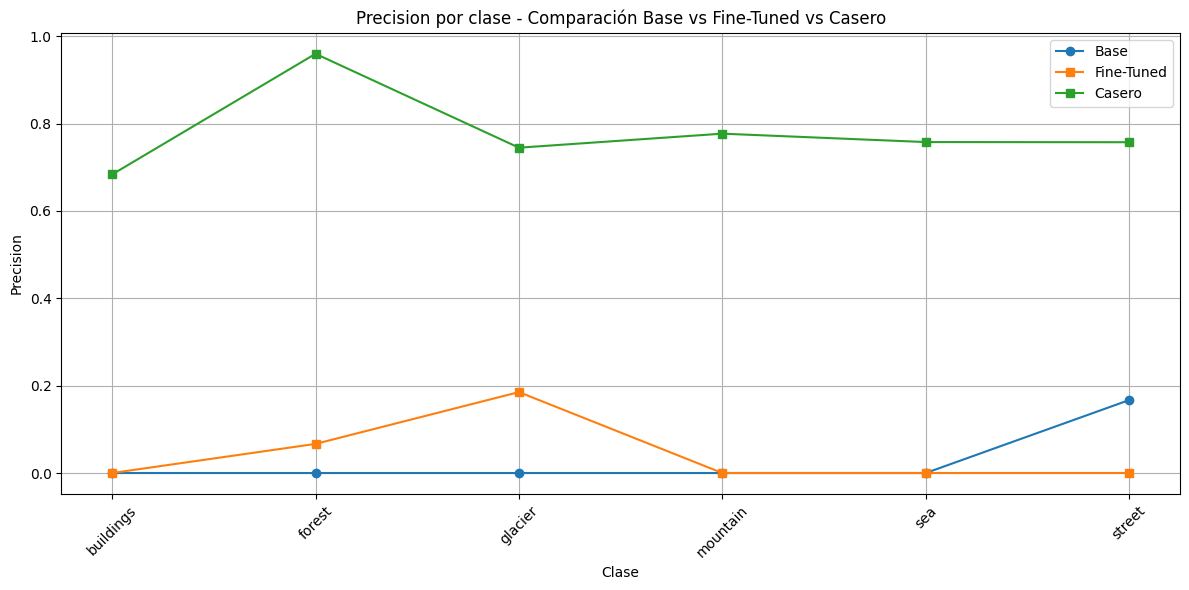

In [45]:
import matplotlib.pyplot as plt

classes = df_compare.index

plt.figure(figsize=(12, 6))
plt.plot(classes, df_compare['precision_base'], marker='o', label='Base')
plt.plot(classes, df_compare['precision_ft'], marker='s', label='Fine-Tuned')
plt.plot(classes, df_compare['precision_casero'], marker='s', label='Casero')

plt.title("Precision por clase - Comparación Base vs Fine-Tuned vs Casero")
plt.xlabel("Clase")
plt.ylabel("Precision")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
